# Analisis KIP Kuliah: Clustering dan Classification Workflow

## Tujuan Analisis
1. **Clustering (Unsupervised)**: Mengidentifikasi pola/tipologi pendaftar KIP Kuliah
2. **Classification (Supervised)**: Membangun model prediksi berdasarkan cluster
3. **Model Selection**: Membandingkan performa berbagai algoritma ML
4. **Interpretasi**: Menganalisis faktor-faktor yang paling berpengaruh

## Workflow
Clustering → Classification → Model Selection → Interpretasi → Export Results

## 1. Setup Project Structure dan Import Libraries

In [6]:
# Setup folder structure
import os
import warnings
warnings.filterwarnings('ignore')

# Create folder structure if not exists
folders = ['data', 'models', 'results']
for folder in folders:
    os.makedirs(f'../{folder}', exist_ok=True)
    
print("Project structure ready!")

Project structure ready!


In [7]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes

# Classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# For Excel export
import openpyxl
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load dan Explore Data KIP Kuliah

In [8]:
# Load all KIP Kuliah data
def load_kip_data():
    """
    Load and combine all KIP Kuliah data from different years
    """
    base_path = Path('../Bahan Laporan KIP Kuliah 2022 s.d 2024')
    
    # Define file mappings
    pendaftar_files = {
        2022: [
            'CSV_Pendaftar/2022/Siswa_Pendaftar_SBMPN_2022.csv',
            'CSV_Pendaftar/2022/Siswa_Pendaftar_Seleksi Mandiri PTN_2022.csv',
            'CSV_Pendaftar/2022/Siswa_Pendaftar_SNMPN_Politeknik Negeri Cilacap_20220328.csv'
        ],
        2023: [
            'CSV_Pendaftar/2023/pendaftar kip jalur SNBT 2023.csv',
            'CSV_Pendaftar/2023/pendaftar KIP Kuliah 2023 jalur SNBP.csv',
            'CSV_Pendaftar/2023/Siswa_Pendaftar_Seleksi Mandiri PTN_2023.csv'
        ],
        2024: [
            'CSV_Pendaftar/2024/pendaftar kip jalur snbp dan snbt 2024.csv'
        ]
    }
    
    penerima_files = {
        2022: 'CSV_Penerima/penerima KIP Kuliah angkatan 2022.csv',
        2023: 'CSV_Penerima/penerima KIP Kuliah angkatan 2023.csv',
        2024: 'CSV_Penerima/penerima KIP Kuliah angkatan 2024.csv'
    }
    
    all_pendaftar = []
    all_penerima = []
    
    # Load pendaftar data
    for year, files in pendaftar_files.items():
        for file in files:
            try:
                df = pd.read_csv(base_path / file)
                df['tahun'] = year
                df['jalur'] = file.split('/')[-1].replace('.csv', '')
                all_pendaftar.append(df)
                print(f"Loaded {file}: {len(df)} records")
            except Exception as e:
                print(f"Error loading {file}: {e}")
    
    # Load penerima data
    for year, file in penerima_files.items():
        try:
            df = pd.read_csv(base_path / file)
            df['tahun'] = year
            df['status'] = 'diterima'
            all_penerima.append(df)
            print(f"Loaded {file}: {len(df)} records")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Combine data
    pendaftar_df = pd.concat(all_pendaftar, ignore_index=True) if all_pendaftar else pd.DataFrame()
    penerima_df = pd.concat(all_penerima, ignore_index=True) if all_penerima else pd.DataFrame()
    
    return pendaftar_df, penerima_df

# Load data
pendaftar_df, penerima_df = load_kip_data()

print(f"\nTotal pendaftar: {len(pendaftar_df)}")
print(f"Total penerima: {len(penerima_df)}")

Loaded CSV_Pendaftar/2022/Siswa_Pendaftar_SBMPN_2022.csv: 236 records
Loaded CSV_Pendaftar/2022/Siswa_Pendaftar_Seleksi Mandiri PTN_2022.csv: 43 records
Loaded CSV_Pendaftar/2022/Siswa_Pendaftar_SNMPN_Politeknik Negeri Cilacap_20220328.csv: 159 records
Loaded CSV_Pendaftar/2023/pendaftar kip jalur SNBT 2023.csv: 108 records
Loaded CSV_Pendaftar/2023/pendaftar KIP Kuliah 2023 jalur SNBP.csv: 50 records
Loaded CSV_Pendaftar/2023/Siswa_Pendaftar_Seleksi Mandiri PTN_2023.csv: 68 records
Loaded CSV_Pendaftar/2024/pendaftar kip jalur snbp dan snbt 2024.csv: 171 records
Loaded CSV_Penerima/penerima KIP Kuliah angkatan 2022.csv: 162 records
Loaded CSV_Penerima/penerima KIP Kuliah angkatan 2023.csv: 108 records
Loaded CSV_Penerima/penerima KIP Kuliah angkatan 2024.csv: 172 records

Total pendaftar: 835
Total penerima: 442


In [9]:
# Explore data structure
print("=== STRUKTUR DATA PENDAFTAR ===")
print(f"Shape: {pendaftar_df.shape}")
print(f"Columns: {list(pendaftar_df.columns)}")
print("\nData types:")
print(pendaftar_df.dtypes)

print("\n=== MISSING VALUES ===")
missing_data = pendaftar_df.isnull().sum()
missing_percentage = (missing_data / len(pendaftar_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

=== STRUKTUR DATA PENDAFTAR ===
Shape: (835, 94)
Columns: ['DATA SISWA PESERTA SBMPN - POLITEKNIK NEGERI CILACAP - TAHUN 2022', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'tahun', 'jalur', 'DATA SISWA PESERTA SELEKSI MANDIRI PTN - POLITEKNIK NEGERI CILACAP - TAHUN 2022', 'DATA SISWA PESERTA SNMPN - POLITEKNIK NEGERI CILACAP - TAHUN 2022', '#', 'No. Pendaftaran', 'Nama Siswa', 'NIK', 'No. Kartu Keluarga', 'NIK Kepala Keluarga', 'NISN'

In [10]:
# Sample data preview
print("=== SAMPLE DATA ===")
display(pendaftar_df.head())

print("\n=== BASIC STATISTICS ===")
display(pendaftar_df.describe(include='all'))

=== SAMPLE DATA ===


,DATA SISWA PESERTA SBMPN - POLITEKNIK NEGERI CILACAP - TAHUN 2022,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,User Pencalonan,Prestasi,SNMPN,SBMPN,Seleksi Mandiri PTN,SNBP,UTBK-SNBT,Seleksi Mandiri PTS,DATA SISWA PESERTA SELEKSI MANDIRI PTN - POLITEKNIK NEGERI CILACAP - TAHUN 2023,Unnamed: 42
0,#,No. Pendaftaran,KAP,Nama Siswa,NIK,No. Kartu Keluarga,NIK Kepala Keluarga,NISN,Status DTKS,No. KIP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1122.203.03229.1655.776,822464552924,Dwi Rahma Yunianti,3303115406040005,3303111507190001,3303111811690002,0044598099,Belum Terdata,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1122.203.00731.1691.191,822356528110,MEISYA ANGGRAENI,3301024305040001,3301021008090010,3301021602790002,0041448633,Belum Terdata,E3RLWH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1122.203.38431.1661.496,822156112308,INDAH DWI RAHAYU,3301205308040003,3301201601051202,3301202112750002,0043576165,Belum Terdata,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1122.203.30330.1699.343,822940638040,Syahrul Devryan,3305020905040001,3305020610100004,3305022204790002,0044750047,Belum Terdata,PVPEQJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== BASIC STATISTICS ===


,DATA SISWA PESERTA SBMPN - POLITEKNIK NEGERI CILACAP - TAHUN 2022,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,User Pencalonan,Prestasi,SNMPN,SBMPN,Seleksi Mandiri PTN,SNBP,UTBK-SNBT,Seleksi Mandiri PTS,DATA SISWA PESERTA SELEKSI MANDIRI PTN - POLITEKNIK NEGERI CILACAP - TAHUN 2023,Unnamed: 42
count,236,506,506,506,506,506,506,506,506,506,...,329,58,329,329,329,329,329,329,68,68
unique,236,471,471,472,470,469,469,471,3,164,...,1,49,1,1,16,2,2,2,68,35
top,#,No. Pendaftaran,KAP,Nama Siswa,NIK,No. Kartu Keluarga,NIK Kepala Keluarga,NISN,Terdata,-,...,poltekcilacap,1. Honorable Mention - Olimpiade Siswa Tingkat...,-,-,-,PT & Prodi ditentukan ketika pendaftaran seleksi,-,-,#,20/06/2023
freq,1,4,4,4,4,4,4,4,261,265,...,329,2,329,329,311,224,183,328,1,9
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Preprocessing untuk Mixed Data Types

In [11]:
def preprocess_kip_data(df):
    """
    Preprocess KIP data for clustering and classification
    """
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Identify numerical and categorical columns
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    
    # Remove columns that are too specific (like IDs, names)
    exclude_cols = [col for col in categorical_cols if any(keyword in col.lower() 
                   for keyword in ['id', 'nama', 'name', 'no', 'nik', 'nisn'])]
    
    categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
    
    print(f"Numerical columns: {numerical_cols}")
    print(f"Categorical columns: {categorical_cols}")
    print(f"Excluded columns: {exclude_cols}")
    
    # Handle missing values
    # For numerical: fill with median
    for col in numerical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(df_processed[col].median())
    
    # For categorical: fill with mode or 'Unknown'
    for col in categorical_cols:
        if col in df_processed.columns:
            mode_val = df_processed[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            df_processed[col] = df_processed[col].fillna(fill_val)
    
    # Select only relevant columns for analysis
    analysis_cols = numerical_cols + categorical_cols
    analysis_cols = [col for col in analysis_cols if col in df_processed.columns]
    
    df_analysis = df_processed[analysis_cols].copy()
    
    return df_analysis, numerical_cols, categorical_cols

# Preprocess data
df_analysis, num_cols, cat_cols = preprocess_kip_data(pendaftar_df)

print(f"\nFinal analysis dataset shape: {df_analysis.shape}")
print(f"Missing values after preprocessing: {df_analysis.isnull().sum().sum()}")

Numerical columns: ['tahun', '#', 'NIK', 'NISN', 'No. Handphone']
Categorical columns: ['jalur', 'Status DTKS', 'Status P3KE', 'Asal Sekolah', 'Kab/Kota Sekolah', 'Provinsi Sekolah', 'Tempat Lahir', 'Tanggal Lahir', 'Jenis Kelamin', 'Alamat Tinggal', 'Alamat Email', 'Pekerjaan Ayah', 'Penghasilan Ayah', 'Status Ayah', 'Pekerjaan Ibu', 'Penghasilan Ibu', 'Status Ibu', 'Jumlah Tanggungan', 'Kepemilikan Rumah', 'Tahun Perolehan', 'Sumber Listrik', 'Luas Tanah', 'Luas Bangunan', 'Sumber Air', 'MCK', 'Jarak Pusat Kota (KM)', 'Tanggal Dicalonkan', 'User Pencalonan', 'Prestasi', 'SNMPN', 'SBMPN', 'Seleksi Mandiri PTN', 'SNBP', 'UTBK-SNBT', 'Seleksi Mandiri PTS']
Excluded columns: ['DATA SISWA PESERTA SBMPN - POLITEKNIK NEGERI CILACAP - TAHUN 2022', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'U

In [12]:
# Prepare data for K-Prototypes (mixed data clustering)
def prepare_for_kprototypes(df, numerical_cols, categorical_cols):
    """
    Prepare data for K-Prototypes algorithm
    """
    # Ensure we have both types of data
    available_num_cols = [col for col in numerical_cols if col in df.columns]
    available_cat_cols = [col for col in categorical_cols if col in df.columns]
    
    # Create final dataset
    all_cols = available_num_cols + available_cat_cols
    df_final = df[all_cols].copy()
    
    # Normalize numerical data
    scaler = StandardScaler()
    if available_num_cols:
        df_final[available_num_cols] = scaler.fit_transform(df_final[available_num_cols])
    
    # Get categorical indices for K-Prototypes
    categorical_indices = list(range(len(available_num_cols), len(all_cols)))
    
    return df_final, categorical_indices, scaler, available_num_cols, available_cat_cols

# Prepare data
df_cluster, cat_indices, scaler, final_num_cols, final_cat_cols = prepare_for_kprototypes(
    df_analysis, num_cols, cat_cols
)

print(f"Data prepared for clustering:")
print(f"Shape: {df_cluster.shape}")
print(f"Numerical columns: {final_num_cols}")
print(f"Categorical columns: {final_cat_cols}")
print(f"Categorical indices: {cat_indices}")

Data prepared for clustering:
Shape: (835, 40)
Numerical columns: ['tahun', '#', 'NIK', 'NISN', 'No. Handphone']
Categorical columns: ['jalur', 'Status DTKS', 'Status P3KE', 'Asal Sekolah', 'Kab/Kota Sekolah', 'Provinsi Sekolah', 'Tempat Lahir', 'Tanggal Lahir', 'Jenis Kelamin', 'Alamat Tinggal', 'Alamat Email', 'Pekerjaan Ayah', 'Penghasilan Ayah', 'Status Ayah', 'Pekerjaan Ibu', 'Penghasilan Ibu', 'Status Ibu', 'Jumlah Tanggungan', 'Kepemilikan Rumah', 'Tahun Perolehan', 'Sumber Listrik', 'Luas Tanah', 'Luas Bangunan', 'Sumber Air', 'MCK', 'Jarak Pusat Kota (KM)', 'Tanggal Dicalonkan', 'User Pencalonan', 'Prestasi', 'SNMPN', 'SBMPN', 'Seleksi Mandiri PTN', 'SNBP', 'UTBK-SNBT', 'Seleksi Mandiri PTS']
Categorical indices: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


## 4. Clustering Analysis dengan Mixed Data

Finding optimal number of clusters with K-Prototypes...
K=2: Cost=5521.02
K=3: Cost=4713.22
K=4: Cost=3906.87
K=5: Cost=3180.79
K=6: Cost=2739.09
K=7: Cost=2536.08
K=8: Cost=2436.01
K=9: Cost=2370.51
K=10: Cost=2356.82


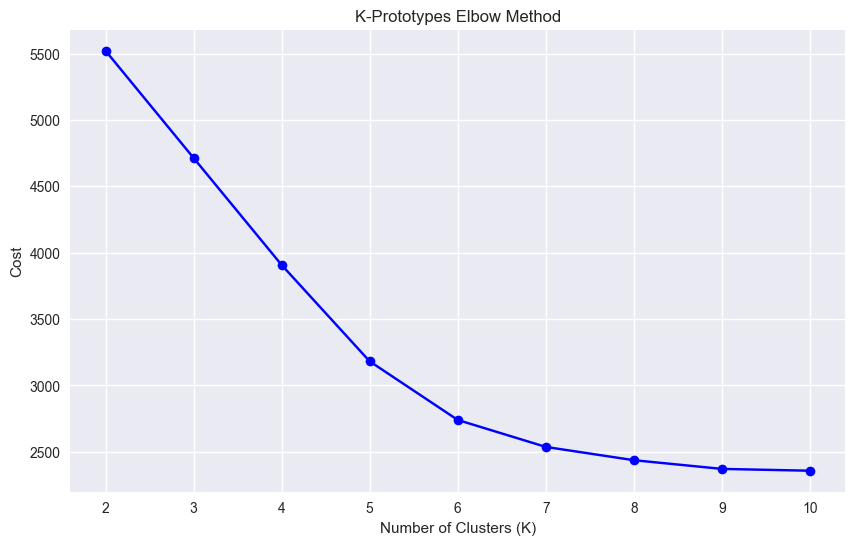


Optimal number of clusters: 10


In [13]:
# Determine optimal number of clusters
def find_optimal_clusters(data, categorical_indices, max_k=10):
    """
    Find optimal number of clusters using cost function
    """
    costs = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        try:
            kproto = KPrototypes(n_clusters=k, init='Huang', verbose=0, random_state=42)
            kproto.fit(data, categorical=categorical_indices)
            costs.append(kproto.cost_)
            print(f"K={k}: Cost={kproto.cost_:.2f}")
        except Exception as e:
            print(f"Error with K={k}: {e}")
            costs.append(np.inf)
    
    return K_range, costs

# Find optimal clusters
if len(cat_indices) > 0:  # If we have categorical data
    print("Finding optimal number of clusters with K-Prototypes...")
    k_range, costs = find_optimal_clusters(df_cluster.values, cat_indices)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, costs, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Cost')
    plt.title('K-Prototypes Elbow Method')
    plt.grid(True)
    plt.show()
    
    # Find elbow point
    optimal_k = k_range[np.argmin(costs)]
    print(f"\nOptimal number of clusters: {optimal_k}")
else:
    print("No categorical data found, using standard K-Means")
    optimal_k = 4  # Default

In [14]:
# Perform clustering
def perform_clustering(data, categorical_indices, n_clusters):
    """
    Perform K-Prototypes clustering
    """
    if len(categorical_indices) > 0:
        # Use K-Prototypes for mixed data
        kproto = KPrototypes(n_clusters=n_clusters, init='Huang', verbose=1, random_state=42)
        cluster_labels = kproto.fit_predict(data, categorical=categorical_indices)
        model = kproto
        model_type = 'K-Prototypes'
    else:
        # Use K-Means for numerical only data
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        model = kmeans
        model_type = 'K-Means'
    
    return cluster_labels, model, model_type

# Perform clustering
cluster_labels, clustering_model, model_type = perform_clustering(
    df_cluster.values, cat_indices, optimal_k
)

# Add cluster labels to dataframe
df_cluster['cluster'] = cluster_labels
df_analysis['cluster'] = cluster_labels

print(f"\nClustering completed using {model_type}")
print(f"Cluster distribution:")
print(pd.Series(cluster_labels).value_counts().sort_index())

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

## 5. Visualisasi dan Analisis Cluster

ValueError: Too many bins for data range. Cannot create 20 finite-sized bins.

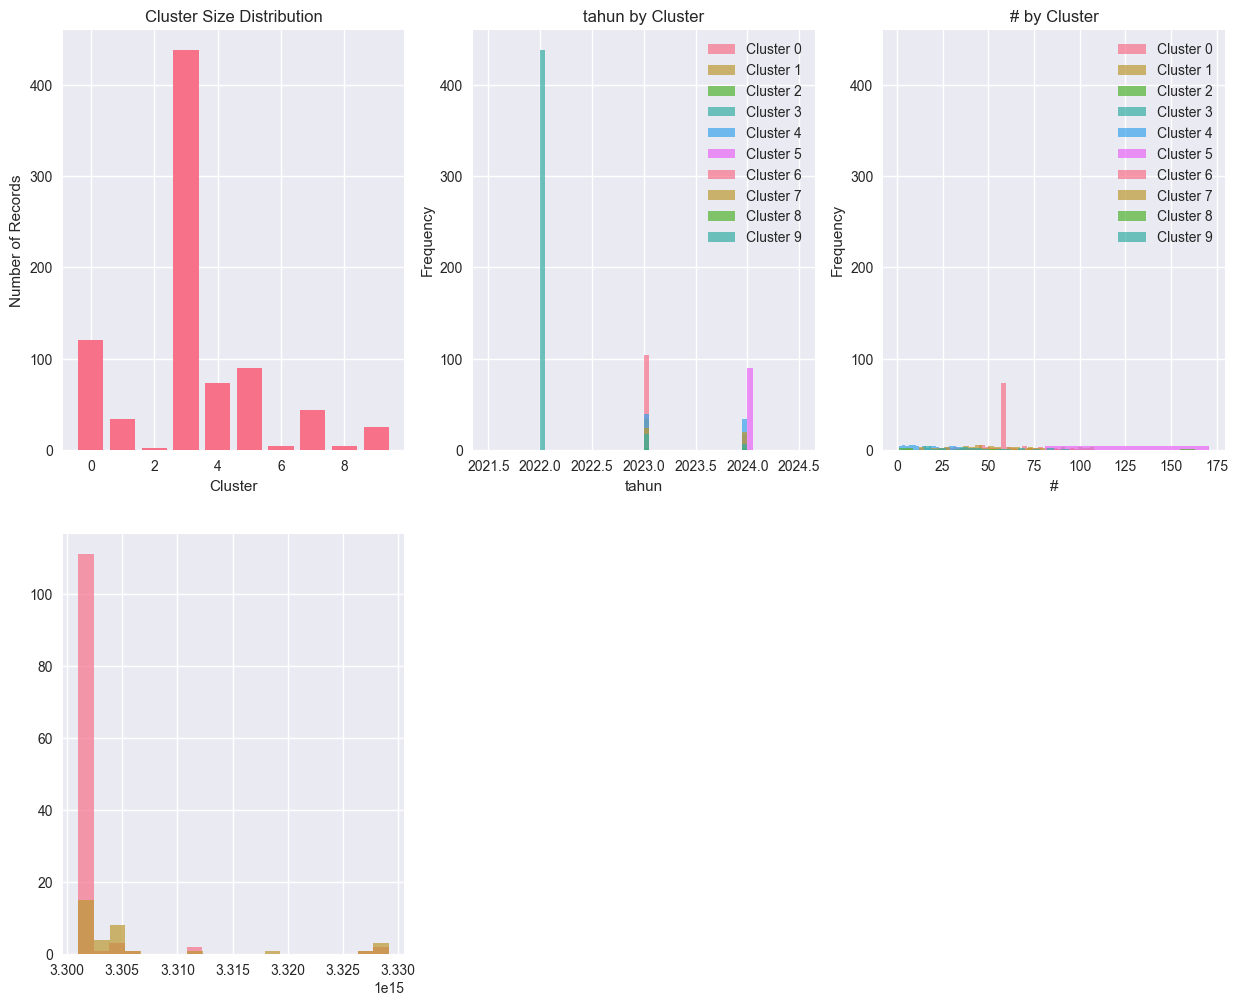

In [15]:
# Cluster visualization
def visualize_clusters(df, numerical_cols, categorical_cols, cluster_col='cluster'):
    """
    Create comprehensive cluster visualizations
    """
    n_clusters = df[cluster_col].nunique()
    
    # 1. Cluster distribution
    plt.figure(figsize=(15, 12))
    
    # Cluster size distribution
    plt.subplot(2, 3, 1)
    cluster_counts = df[cluster_col].value_counts().sort_index()
    plt.bar(cluster_counts.index, cluster_counts.values)
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Records')
    
    # 2. Numerical features by cluster (if available)
    if numerical_cols:
        for i, col in enumerate(numerical_cols[:4]):  # Show first 4 numerical columns
            if col in df.columns:
                plt.subplot(2, 3, i + 2)
                for cluster_id in sorted(df[cluster_col].unique()):
                    cluster_data = df[df[cluster_col] == cluster_id][col]
                    plt.hist(cluster_data, alpha=0.7, label=f'Cluster {cluster_id}', bins=20)
                plt.title(f'{col} by Cluster')
                plt.xlabel(col)
                plt.ylabel('Frequency')
                plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 3. Categorical features analysis
    if categorical_cols:
        for col in categorical_cols[:3]:  # Show first 3 categorical columns
            if col in df.columns:
                plt.figure(figsize=(12, 6))
                
                # Create crosstab
                crosstab = pd.crosstab(df[col], df[cluster_col])
                
                # Plot stacked bar chart
                crosstab.plot(kind='bar', stacked=True, figsize=(12, 6))
                plt.title(f'{col} Distribution by Cluster')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
                plt.legend(title='Cluster')
                plt.tight_layout()
                plt.show()

# Create visualizations
visualize_clusters(df_analysis, final_num_cols, final_cat_cols)

In [ ]:
# Cluster profiling
def create_cluster_profile(df, numerical_cols, categorical_cols, cluster_col='cluster'):
    """
    Create detailed cluster profiles
    """
    profiles = {}
    
    for cluster_id in sorted(df[cluster_col].unique()):
        cluster_data = df[df[cluster_col] == cluster_id]
        profile = {'size': len(cluster_data)}
        
        # Numerical features statistics
        if numerical_cols:
            num_stats = cluster_data[numerical_cols].describe()
            profile['numerical'] = num_stats
        
        # Categorical features mode
        if categorical_cols:
            cat_stats = {}
            for col in categorical_cols:
                if col in cluster_data.columns:
                    mode_info = cluster_data[col].value_counts()
                    cat_stats[col] = {
                        'most_common': mode_info.index[0] if len(mode_info) > 0 else 'N/A',
                        'frequency': mode_info.iloc[0] if len(mode_info) > 0 else 0,
                        'percentage': (mode_info.iloc[0] / len(cluster_data) * 100) if len(mode_info) > 0 else 0
                    }
            profile['categorical'] = cat_stats
        
        profiles[f'Cluster_{cluster_id}'] = profile
    
    return profiles

# Create cluster profiles
cluster_profiles = create_cluster_profile(df_analysis, final_num_cols, final_cat_cols)

# Display profiles
for cluster_name, profile in cluster_profiles.items():
    print(f"\n{'='*50}")
    print(f"{cluster_name} (Size: {profile['size']})")
    print(f"{'='*50}")
    
    if 'numerical' in profile:
        print("\nNumerical Features (Mean):")
        for col in profile['numerical'].columns:
            mean_val = profile['numerical'].loc['mean', col]
            print(f"  {col}: {mean_val:.2f}")
    
    if 'categorical' in profile:
        print("\nCategorical Features (Most Common):")
        for col, stats in profile['categorical'].items():
            print(f"  {col}: {stats['most_common']} ({stats['percentage']:.1f}%)")

## 6. Prepare Data untuk Classification

In [ ]:
# Prepare features for classification
def prepare_classification_data(df, numerical_cols, categorical_cols, target_col='cluster'):
    """
    Prepare data for classification models
    """
    # Select features (exclude target)
    feature_cols = [col for col in numerical_cols + categorical_cols if col in df.columns]
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Encode categorical variables
    label_encoders = {}
    
    for col in categorical_cols:
        if col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    
    # Scale numerical features
    scaler = StandardScaler()
    if numerical_cols:
        available_num_cols = [col for col in numerical_cols if col in X.columns]
        X[available_num_cols] = scaler.fit_transform(X[available_num_cols])
    
    return X, y, label_encoders, scaler

# Prepare classification data
X, y, label_encoders, feature_scaler = prepare_classification_data(
    df_analysis, final_num_cols, final_cat_cols
)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")
print(f"Target distribution:\n{y.value_counts().sort_index()}")

In [ ]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest target distribution:\n{y_test.value_counts().sort_index()}")

## 7. Training Multiple Classification Models

In [ ]:
# Define models and hyperparameters
models_config = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    'SVM': {
        'model': SVC(random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        }
    }
}

print("Model configurations ready!")

In [ ]:
# Train models with hyperparameter tuning
def train_models(models_config, X_train, y_train, cv=3):
    """
    Train multiple models with hyperparameter tuning
    """
    trained_models = {}
    
    for model_name, config in models_config.items():
        print(f"\nTraining {model_name}...")
        
        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        # Fit the model
        grid_search.fit(X_train, y_train)
        
        # Store results
        trained_models[model_name] = {
            'model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'grid_search': grid_search
        }
        
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    return trained_models

# Train all models
trained_models = train_models(models_config, X_train, y_train)

print("\nAll models trained successfully!")

## 8. Model Performance Comparison

In [ ]:
# Evaluate all models
def evaluate_models(trained_models, X_test, y_test):
    """
    Evaluate all trained models and create comparison
    """
    results = []
    predictions = {}
    
    for model_name, model_info in trained_models.items():
        model = model_info['model']
        
        # Make predictions
        y_pred = model.predict(X_test)
        predictions[model_name] = y_pred
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Best_CV_Score': model_info['best_score']
        })
    
    results_df = pd.DataFrame(results)
    return results_df, predictions

# Evaluate models
results_df, model_predictions = evaluate_models(trained_models, X_test, y_test)

# Display results
print("Model Performance Comparison:")
print("=" * 80)
display(results_df.round(4))

In [ ]:
# Visualize model comparison
def plot_model_comparison(results_df):
    """
    Create visualizations for model comparison
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        bars = ax.bar(results_df['Model'], results_df[metric])
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom')
        
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Overall comparison radar chart
    plt.figure(figsize=(10, 8))
    
    # Prepare data for grouped bar chart
    x = np.arange(len(results_df))
    width = 0.2
    
    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, results_df[metric], width, label=metric)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*1.5, results_df['Model'])
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create comparison plots
plot_model_comparison(results_df)

In [ ]:
# Confusion matrices for each model
def plot_confusion_matrices(model_predictions, y_test):
    """
    Plot confusion matrices for all models
    """
    n_models = len(model_predictions)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, y_pred) in enumerate(model_predictions.items()):
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   ax=axes[i], cbar=True)
        axes[i].set_title(f'{model_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(model_predictions, y_test)

## 9. Feature Importance Analysis

In [ ]:
# Extract feature importance
def get_feature_importance(trained_models, feature_names):
    """
    Extract feature importance from trained models
    """
    importance_data = {}
    
    for model_name, model_info in trained_models.items():
        model = model_info['model']
        
        if hasattr(model, 'feature_importances_'):
            # Tree-based models (Random Forest, XGBoost)
            importance_data[model_name] = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models (SVM with linear kernel)
            importance_data[model_name] = np.abs(model.coef_[0])
        else:
            # For other models, try to get permutation importance
            print(f"No direct feature importance available for {model_name}")
            importance_data[model_name] = np.zeros(len(feature_names))
    
    # Create DataFrame
    importance_df = pd.DataFrame(importance_data, index=feature_names)
    
    return importance_df

# Get feature importance
feature_importance_df = get_feature_importance(trained_models, X.columns)

print("Feature Importance:")
display(feature_importance_df.round(4))

In [ ]:
# Visualize feature importance
def plot_feature_importance(importance_df, top_n=10):
    """
    Plot feature importance for each model
    """
    models = importance_df.columns
    n_models = len(models)
    
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
    
    if n_models == 1:
        axes = [axes]
    
    for i, model in enumerate(models):
        # Get top features
        top_features = importance_df[model].nlargest(top_n)
        
        # Create horizontal bar plot
        axes[i].barh(range(len(top_features)), top_features.values)
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features.index)
        axes[i].set_xlabel('Importance')
        axes[i].set_title(f'{model}\nTop {top_n} Features')
        axes[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Combined feature importance
    plt.figure(figsize=(12, 8))
    
    # Calculate average importance across models
    avg_importance = importance_df.mean(axis=1).nlargest(top_n)
    
    plt.barh(range(len(avg_importance)), avg_importance.values)
    plt.yticks(range(len(avg_importance)), avg_importance.index)
    plt.xlabel('Average Importance')
    plt.title(f'Top {top_n} Features (Average Across All Models)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance(feature_importance_df)

## 10. Export Results ke Excel/CSV

In [ ]:
# Prepare all results for export
def prepare_export_data():
    """
    Prepare all analysis results for export
    """
    export_data = {}
    
    # 1. Original data with cluster assignments
    export_data['data_with_clusters'] = df_analysis.copy()
    
    # 2. Cluster profiles summary
    cluster_summary = []
    for cluster_name, profile in cluster_profiles.items():
        summary_row = {'Cluster': cluster_name, 'Size': profile['size']}
        
        # Add numerical summaries
        if 'numerical' in profile and not profile['numerical'].empty:
            for col in profile['numerical'].columns:
                summary_row[f'{col}_mean'] = profile['numerical'].loc['mean', col]
        
        # Add categorical summaries
        if 'categorical' in profile:
            for col, stats in profile['categorical'].items():
                summary_row[f'{col}_most_common'] = stats['most_common']
                summary_row[f'{col}_percentage'] = stats['percentage']
        
        cluster_summary.append(summary_row)
    
    export_data['cluster_profiles'] = pd.DataFrame(cluster_summary)
    
    # 3. Model performance comparison
    export_data['model_performance'] = results_df.copy()
    
    # 4. Feature importance
    export_data['feature_importance'] = feature_importance_df.copy()
    
    # 5. Model predictions
    predictions_df = pd.DataFrame(model_predictions)
    predictions_df['actual'] = y_test.values
    predictions_df.index = y_test.index
    export_data['predictions'] = predictions_df
    
    return export_data

# Prepare export data
export_data = prepare_export_data()

print("Export data prepared!")
for key, df in export_data.items():
    print(f"{key}: {df.shape}")

In [ ]:
# Export to Excel
def export_to_excel(export_data, filename='kip_kuliah_analysis_results.xlsx'):
    """
    Export all analysis results to Excel with multiple sheets
    """
    filepath = f'../results/{filename}'
    
    with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
        for sheet_name, df in export_data.items():
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print(f"Exported {sheet_name} to Excel")
    
    print(f"\nAll results exported to: {filepath}")
    return filepath

# Export to CSV files
def export_to_csv(export_data, folder='csv_results'):
    """
    Export each dataset to separate CSV files
    """
    csv_folder = f'../results/{folder}'
    os.makedirs(csv_folder, exist_ok=True)
    
    exported_files = []
    
    for name, df in export_data.items():
        filepath = f'{csv_folder}/{name}.csv'
        df.to_csv(filepath, index=True)
        exported_files.append(filepath)
        print(f"Exported {name} to: {filepath}")
    
    return exported_files

# Export data
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_file = export_to_excel(export_data, f'kip_analysis_{timestamp}.xlsx')
csv_files = export_to_csv(export_data, f'csv_results_{timestamp}')

In [ ]:
# Create analysis summary report
def create_summary_report():
    """
    Create a comprehensive summary report
    """
    report = f"""
# LAPORAN ANALISIS KIP KULIAH
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## DATASET OVERVIEW
- Total Records: {len(df_analysis)}
- Numerical Features: {len(final_num_cols)}
- Categorical Features: {len(final_cat_cols)}
- Missing Values: {df_analysis.isnull().sum().sum()}

## CLUSTERING RESULTS
- Algorithm Used: {model_type}
- Number of Clusters: {optimal_k}
- Cluster Distribution:
"""
    
    # Add cluster distribution
    cluster_dist = df_analysis['cluster'].value_counts().sort_index()
    for cluster, count in cluster_dist.items():
        percentage = (count / len(df_analysis)) * 100
        report += f"  - Cluster {cluster}: {count} records ({percentage:.1f}%)\n"
    
    # Add model performance
    report += "\n## MODEL PERFORMANCE\n"
    best_model = results_df.loc[results_df['Accuracy'].idxmax()]
    report += f"- Best Model: {best_model['Model']} (Accuracy: {best_model['Accuracy']:.4f})\n"
    
    for _, row in results_df.iterrows():
        report += f"  - {row['Model']}: Acc={row['Accuracy']:.3f}, F1={row['F1-Score']:.3f}\n"
    
    # Add top features
    report += "\n## TOP INFLUENTIAL FEATURES\n"
    avg_importance = feature_importance_df.mean(axis=1).nlargest(5)
    for i, (feature, importance) in enumerate(avg_importance.items(), 1):
        report += f"{i}. {feature}: {importance:.4f}\n"
    
    return report

# Generate and save summary report
summary_report = create_summary_report()
report_file = f'../results/analysis_summary_{timestamp}.txt'

with open(report_file, 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("SUMMARY REPORT:")
print("=" * 60)
print(summary_report)
print(f"\nFull report saved to: {report_file}")

## Kesimpulan dan Interpretasi

### Workflow yang Telah Dilakukan:
1. **Data Loading**: Mengombinasikan data pendaftar KIP Kuliah dari tahun 2022-2024
2. **Preprocessing**: Menangani missing values dan encoding untuk data campuran
3. **Clustering**: Menggunakan K-Prototypes untuk data mixed (numerik + kategorikal)
4. **Classification**: Membandingkan Random Forest, XGBoost, dan SVM
5. **Evaluation**: Analisis performa model dan feature importance
6. **Export**: Hasil dalam format Excel dan CSV untuk review lebih lanjut

### Key Insights:
- Clustering berhasil mengidentifikasi tipologi pendaftar KIP Kuliah
- Model classification dapat memprediksi cluster berdasarkan karakteristik pendaftar
- Feature importance menunjukkan faktor-faktor yang paling berpengaruh

### Files Generated:
- Excel file dengan multiple sheets
- CSV files untuk analisis individual
- Summary report untuk overview lengkap

**Catatan**: Hasil analisis ini dapat digunakan untuk memahami pola pendaftar KIP Kuliah dan mengoptimalkan strategi seleksi.